In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We import the monte carlo code written in the `montecarlo.py` file

In [3]:
from montecarlo import monte_carlo

# Weak (in probability) and Strong Convergence (almost surely)

In this notebook we analyze the concepts of weak and strong convergence. 

Before we do so it is useful to recall the definition of limits. Let $a_1,a_2,\ldots$ be a sequence of real numbers. 

Then $\lim_{n\to\infty} a_n = a$ means that for every $\epsilon > 0$ there exists a number $k > 0$ such that
\begin{equation}
|a_{n_0} - a| \leq \epsilon
\end{equation}
for all $n_0 > k.$ 

## Almost sure, with probability 1, almost everywhere
Almost sure convergence is given by $P(\lim_{n \to \infty} X_{n} = X) = 1.$ Let us write this probability very explicitly in terms of the underlying sample space $\Omega$ and probability measure $P$

\begin{equation}
P\left (\lim_{n \to \infty} X_n = X\right) \leftrightarrow P\left(\left\{ \omega; \omega \in \Omega, \lim_{n \to \infty} X_{n}(\omega) = X(\omega) \right \} \right)
\end{equation}
This statement is almost pointwise convergence, it is a statement that all paths $X_n(\omega)$ (as a function of $n$) converge to $X(\omega)$, _except for a set of paths that have measure zero._

Here the event about which we are reasoning is the set $A = \left\{ \omega; \omega \in \Omega, \lim_{n \to \infty} 
X_{n}(\omega) = X(\omega) \right\}.$

An equivalent result  is that for every $\epsilon > 0$ 
\begin{equation}
\lim_{n \to \infty} P\left(\left\{ \omega; \omega \in \Omega,  \exists k \geq n \ |X_{k}(\omega) - X(\omega)| > \epsilon \right \} \right) = 0
\end{equation}
Let us define this corresponding set as 

\begin{equation}
A^{as}_{\epsilon,n} = \left\{ \omega; \omega \in \Omega,  \exists k \geq n \ |X_{k}(\omega) - X(\omega)| > \epsilon \right \}
\end{equation}

So that the statement reads: for all $\epsilon > 0$
\begin{equation}
\lim_{n \to \infty} P(A^{as}_{\epsilon, n}) = 0
\end{equation}

(see Lemma 1 in the paper *Understanding Convergence Concepts: A Visual-Minded and Graphical Simulation-Based Approach* uploaded under Files/ProbabilityTheory for more details)

*In words: convergence almost surely requires that the probability that there exists a $k\ge n$ such that $X_k$ deviates from $X$ by at least $\epsilon$ tends to $0$ as $n$ tends to infinity (for every $\epsilon>0$).*

## Convergence in probability

Convergence in probability means that for all $\epsilon > 0$ $\lim_{n \to \infty} P( |X_n - X| > \epsilon) = 0.$ 

We can define the set we are reasoning about as
\begin{equation}
A^{p}_{\epsilon, n} = \left \{ \omega; \omega \in \Omega, |X_n(\omega) - X(\omega)| > \epsilon  \right \}.
\end{equation}

Now the statement reads: for all $\epsilon > 0$
\begin{equation}
\lim_{n \to \infty} P(A^p_{\epsilon, n}) = 0
\end{equation}

*In words: convergence in probability refers to the fact that the probability that $X_n$ deviates from $X$ by at least $\epsilon$ goes to zero.* 
## Comparison
We now look to compare these two modes of convergence to demonstrate that convergence almost surely implies convergence in probability. To this end we try to answer the question: How are the sets $A^{as}_{\epsilon, n}$ and $A^{p}_{\epsilon, n}$ related? Is one set contained in the other set?


\begin{align}
A^{as}_{\epsilon,n} &= \left\{ \omega; \omega \in \Omega,  \exists k \geq n \ |X_{k}(\omega) - X(\omega)| > \epsilon \right \} \\
A^{p}_{\epsilon, n} &= \left \{ \omega; \omega \in \Omega, |X_n(\omega) - X(\omega)| > \epsilon  \right \}.
\end{align}

Since $A_{\epsilon, n}^{p} \subset A_{\epsilon, n}^{as}$ for all $\epsilon$ and $n$, the rules of probability require 
$P(A_{\epsilon, n}^{p}) < P(A_{\epsilon, n}^{as}).$ As a result, the properties governing convergence of sequences implies that almost sure convergence necessarily also means convergence in probability.

## Numerical demonstration

Lets write a code to compute the probability of $A_{\epsilon, n}^{as}$ and $A_{\epsilon, n}^{p}$ from a trace of samples. Since we don't have analytical expressions for these terms, we will use Monte Carlo to estimator from samples of paths

\begin{equation}
P(A_{\epsilon, n}^{as}) = \mathbb{E}\left[ 1_{A_{\epsilon, n}^{as}}\right]
\approx \frac{\text{\# of paths in } A_{\epsilon, n}^{as}}{\text{Number of total path simulations}}
\end{equation}

and similarly for the set $A_{\epsilon, n}^{p}.$

In [4]:
def estimate_probability_prob(sample_path_errs: np.ndarray,
                              epsilon: float,
                              n: int):
    """Estimate the probability of the event related to convergence in probability.

    Args:

        sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
        epsilon: float, target error region
        n: positive integer
    """

    Npaths, Nsamples_per_path = sample_path_errs.shape
    estimate = np.sum(sample_path_errs[:, n-1] > epsilon) / float(Npaths)  # n-1 because indexing by zero
    return estimate

def estimate_probability_as(sample_path_errs: np.ndarray,
                            epsilon: float,
                            n: int):
    """ Estimate the probability of the event related to convergence almost surely

    Args:
        sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
        epsilon: float, target error region
        n: positive integer

    Note:
    ----
    This function is a bit inefficient, it would be better if n could be a list of variables so that we can reuse
    the calculations
    """

    Npaths, Nsamples_per_path = sample_path_errs.shape
    # Note the difference from in probability ---- we are looking into the future
    # We are looking if any value in the path satisfies the error condition
    paths_satisfy_condition = np.any(sample_path_errs[:, n-1:] > epsilon, axis=1)
    estimate = np.sum(paths_satisfy_condition) / float(Npaths)
    return estimate

### Looking at weak convergence

Weak convergence means refers to convergence in probability. Lets try to estimate the mean of a standard normal random variable using Monte Carlo. Let us also fix an error tolerance $\epsilon$. 

Now we plot the traces of the MC sample average random variable $S_n.$ 

In [5]:
num_trials = 1000
num_samples = 2000
sampler = np.random.randn
def g(x: np.ndarray) -> np.ndarray:
    """Identity function"""
    return x
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    mc = monte_carlo(num_samples, sampler, g, cumsum=True)
    estimator_vals[trial, :] = mc.estimate
epsilon = 0.05

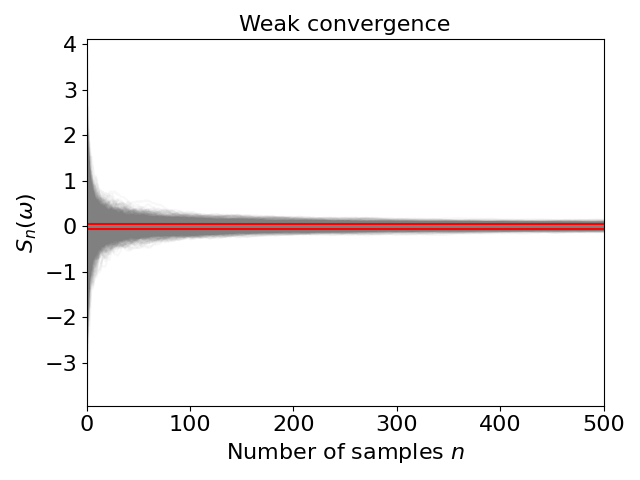

In [14]:
plt.figure()
plt.plot(np.arange(1, num_samples+1), estimator_vals.T, color='grey', alpha=0.05)
plt.axhline(y=epsilon, color='red')
plt.axhline(y=-epsilon, color='red')
plt.title('Weak convergence', fontsize=16)
plt.ylabel(r'$S_n(\omega)$', fontsize=16)
plt.xlabel(r'Number of samples $n$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0, 500])
plt.tight_layout()
plt.show()

This is the plot to think about when we look at the probability of the sets.

## Weak vs Strong Convergence

We now compare weak vs strong convergence by computing their probability for a target error of $\epsilon$. Remember, strong convergence (almost sure) means that for each sample of $S_n(\omega)$ (viewed as a function of $n$) there exists some $k \geq n$ sometime in the future, where the error is smaller than $\epsilon$. Whereas for weak convergence, we care about the probability that the fraction of traces are less than epsilon.

In [7]:
n = np.arange(1, num_samples+1)
prob_as = np.zeros((n.shape[0]))  # probability almost surely
prob_p = np.zeros((n.shape[0]))
for ii, nn in enumerate(n):
    # we take absolute values because the true answer is 0
    prob_as[ii] = estimate_probability_as(np.abs(estimator_vals), epsilon, nn)
    prob_p[ii] = estimate_probability_prob(np.abs(estimator_vals), epsilon, nn)

In [8]:
prob_as

array([1.   , 1.   , 1.   , ..., 0.029, 0.029, 0.029])

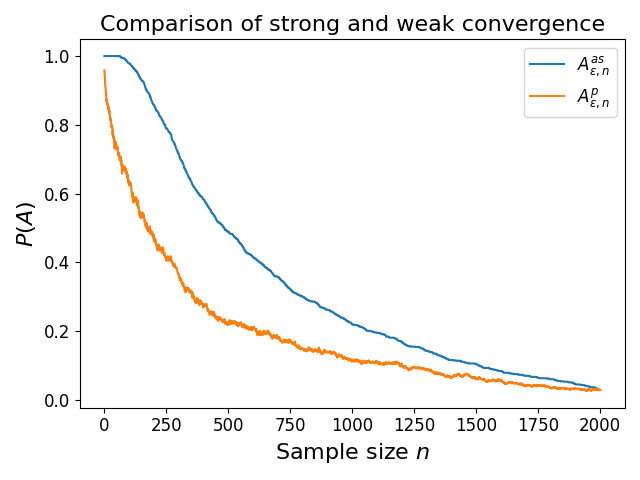

In [13]:
plt.figure()
plt.plot(n, prob_as, label=r'$A_{\epsilon, n}^{as}$')
plt.plot(n, prob_p, label=r'$A_{\epsilon, n}^{p}$')
plt.title('Comparison of strong and weak convergence', fontsize=16)
plt.ylabel(r'$P(A)$', fontsize=16)
plt.xlabel(r'Sample size $n$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
